In [9]:
!mkdir ../checkpoints
!wget https://download.openmmlab.com/mmsegmentation/v0.5/pspnet/pspnet_r50-d8_512x1024_40k_cityscapes/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth -P ../checkpoints

--2022-12-13 00:22:39--  https://download.openmmlab.com/mmsegmentation/v0.5/pspnet/pspnet_r50-d8_512x1024_40k_cityscapes/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.252.96.15
Connecting to download.openmmlab.com (download.openmmlab.com)|47.252.96.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 196205945 (187M) [application/octet-stream]
Saving to: ‘../checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth’

pspnet_r50-d8_512x1 100%[===================>] 187.12M  9.43MB/s    in 20s     

2022-12-13 00:23:02 (9.25 MB/s) - ‘../checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth’ saved [196205945/196205945]



In [1]:
from mmseg.apis import init_segmentor, inference_segmentor, show_result_pyplot
from mmseg.core.evaluation import get_palette

/home/mkutuga/anaconda3/envs/mmseg/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/mkutuga/anaconda3/envs/mmseg/lib/python3.10/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


In [7]:
from mmseg.apis import set_random_seed
from mmseg.utils import get_device
from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset
from mmcv import Config
import os.path as osp
import numpy as np
from PIL import Image
import torch, torchvision
from pathlib import Path
import random
import matplotlib.pyplot as plt
import mmcv


data_root = 'mmsegmentation/example'
img_dir = 'images'
ann_dir = 'labels'

config_file = Path('../configs/pspnet/pspnet_r50-d8_512x1024_40k_cityscapes.py')
checkpoint_file = "/home/mkutuga/mmsegmentation/demo/mmsegmentation/work_dirs/10000_epochs/iter_99500.pth"
# checkpoint_file = '../checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth'
# checkpoint_file = "/home/mkutuga/mmsegmentation/demo/mmsegmentation/work_dirs/tutorial/iter_9000.pth"




cls_txt = "/home/mkutuga/data/example/classes.txt"
# Read metadata
classes = list()
palette = list()
with open(cls_txt, 'r') as f:
    for line in f:
        line = line.rstrip().split(",")
        classes.append(line[1])
        pal = [int(line[2]), int(line[3]), int(line[4])]
        palette.append(pal)
print("Number of classes: ", len(classes))

model = torch.load(checkpoint_file)
model['meta']['PALETTE'] = palette
checkpoint_file = Path('/home/mkutuga/mmsegmentation/demo/mmsegmentation/work_dirs/10000_epochs/iter_99500_palette.pth.pth')
torch.save(model, checkpoint_file)

Number of classes:  41


In [8]:
cfg = Config.fromfile('../configs/pspnet/pspnet_r50-d8_512x1024_40k_cityscapes.py')

# Since we use only one GPU, BN is used instead of SyncBN
cfg.norm_cfg = dict(type='BN', requires_grad=True)
cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg
# modify num classes of the model in decode/auxiliary head
cfg.model.decode_head.num_classes = 41
cfg.model.auxiliary_head.num_classes = 41

# Modify dataset type and path
cfg.dataset_type = 'StanfordBackgroundDataset'
cfg.data_root = data_root

cfg.data.samples_per_gpu = 8
cfg.data.workers_per_gpu=8

cfg.img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
cfg.crop_size = (256, 256)
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(512, 512), ratio_range=(0.5, 2.0)),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(type='Normalize', **cfg.img_norm_cfg),
    dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg']),
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(512, 512),
        # img_ratios=[0.5, 0.75, 1.0, 1.25, 1.5, 1.75],
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(type='Normalize', **cfg.img_norm_cfg),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]


cfg.data.train.type = cfg.dataset_type
cfg.data.train.data_root = cfg.data_root
cfg.data.train.img_dir = img_dir
cfg.data.train.ann_dir = ann_dir
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = 'splits/train.txt'

cfg.data.val.type = cfg.dataset_type
cfg.data.val.data_root = cfg.data_root
cfg.data.val.img_dir = img_dir
cfg.data.val.ann_dir = ann_dir
cfg.data.val.pipeline = cfg.test_pipeline
cfg.data.val.split = 'splits/val.txt'

cfg.data.test.type = cfg.dataset_type
cfg.data.test.data_root = cfg.data_root
cfg.data.test.img_dir = img_dir
cfg.data.test.ann_dir = ann_dir
cfg.data.test.pipeline = cfg.test_pipeline
cfg.data.test.split = 'splits/val.txt'

# We can still use the pre-trained Mask RCNN model though we do not need to
# use the mask branch
cfg.load_from = checkpoint_file

# Set up working dir to save files and logs.
cfg.work_dir = './work_dirs/tutorial'

cfg.runner.max_iters = 20000
cfg.log_config.interval = 10
cfg.evaluation.interval = 500
cfg.checkpoint_config.interval = 500

# Set seed to facitate reproducing the result
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)
cfg.device = get_device()

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

YapfError: <unknown>:190:75: invalid decimal literal

In [ ]:
# build the model from a config file and a checkpoint file
model = init_segmentor(cfg, checkpoint_file, device='cuda:0')

/home/mkutuga/mmsegmentation/demo/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


TypeError: expected string or bytes-like object

In [35]:
import matplotlib.patches as mpatches


def show_result_local_pyplot(model,
                       img,
                       result,
                       palette=None,
                       fig_size=(15, 10),
                       opacity=0.5,
                       title='',
                       block=True,
                       show_legend=False,
                       classes=None,
                       out_file=None):
    """Visualize the segmentation results on the image.

    Args:
        model (nn.Module): The loaded segmentor.
        img (str or np.ndarray): Image filename or loaded image.
        result (list): The segmentation result.
        palette (list[list[int]]] | None): The palette of segmentation
            map. If None is given, random palette will be generated.
            Default: None
        fig_size (tuple): Figure size of the pyplot figure.
        opacity(float): Opacity of painted segmentation map.
            Default 0.5.
            Must be in (0, 1] range.
        title (str): The title of pyplot figure.
            Default is ''.
        block (bool): Whether to block the pyplot figure.
            Default is True.
        out_file (str or None): The path to write the image.
            Default: None.
    """
    if hasattr(model, 'module'):
        model = model.module
    img = model.show_result(
        img, result, palette=palette, show=False, opacity=opacity)
    plt.figure(figsize=fig_size)
    plt.imshow(mmcv.bgr2rgb(img))
    if show_legend:
        # create a patch (proxy artist) for every color
        patches = [
            mpatches.Patch(
                color=np.array(palette[i]) / 255., label=classes[i])
            for i in range(8)
        ]
        # put those patched as legend-handles into the legend
        plt.legend(
            handles=patches,
            bbox_to_anchor=(1.05, 1),
            loc=2,
            borderaxespad=0.,
            fontsize='large')
    plt.title(title)
    plt.tight_layout()
    plt.show(block=block)
    if out_file is not None:
        mmcv.imwrite(img, out_file)


In [36]:
import pandas as pd
csv = "/home/psa_images/Pipeline/SemiF-InspectCutouts/data/summer_weeds_2022/summer_weeds_2022.csv"
df = pd.read_csv(csv, low_memory=False)
df["temp_cropout_path"] = "/home/psa_images/Pipeline/SemiF-AnnotationPipeline/data/semifield-cutouts/" + df["cutout_path"]

In [54]:

ampa = df[df["USDA_symbol"]=="GLMA4"]
cat_list = [x for x in list(ampa["temp_cropout_path"]) if Path(x).exists()]

3113


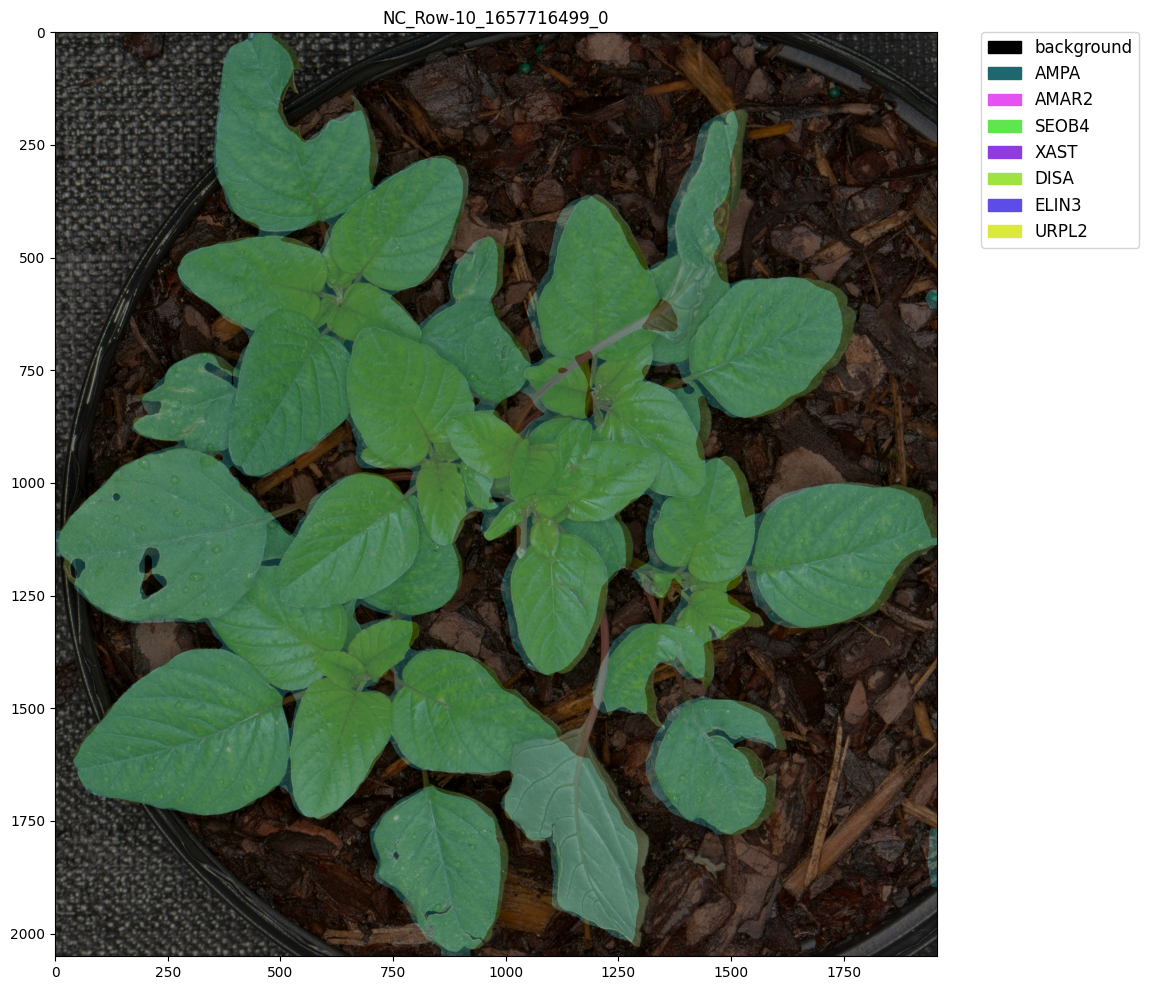

In [71]:

print(len(cat_list))
img = random.choice(cat_list).replace(".png", ".jpg")
# test a single image
result = inference_segmentor(model, img)
# show the results
show_result_local_pyplot(model, img, result, get_palette("psa"), title=Path(img).stem,out_file=f"../assets/{Path(img).stem}_{config_file.stem}_{checkpoint_file.stem}.png", show_legend=True, classes=classes)

In [ ]:
# Let's take a look at the segmentation map we got
img = Image.open('iccv09Data/labels/6000124.png')
plt.figure(figsize=(8, 6))
im = plt.imshow(np.array(img.convert('RGB')))

# create a patch (proxy artist) for every color 
patches = [mpatches.Patch(color=np.array(palette[i])/255., 
                          label=classes[i]) for i in range(8)]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., 
           fontsize='large')

plt.show()